In [1]:
'''
First step of this workshop is initializing OpenVINO environment in this Jupyter notebook. 
The OpenVINO 2020 R1 package have been installed to `intel/openvino/` already.
For initializing the OpenVINO environment you should run thw script 'intel/openvino/bin/setupvars.sh'
'''
!bash intel/openvino/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


In [2]:
'''Lets try to check the environment'''
!echo LD_LIBRARY_PATH is $LD_LIBRARY_PATH
!echo
!echo PYTHONPATH is $PYTHONPATH
'''
As you can see there are paths to the OpenVINO in LD_LIBRARY_PATH and PYTHONPATH variables.
So you can already use the OpenVINO
'''

LD_LIBRARY_PATH is /home/atugarev/intel/openvino_2020.1.016/opencv/lib:/home/atugarev/intel/openvino_2020.1.016/deployment_tools/ngraph/lib:/opt/intel/opencl:/home/atugarev/intel/openvino_2020.1.016/deployment_tools/inference_engine/external/hddl/lib:/home/atugarev/intel/openvino_2020.1.016/deployment_tools/inference_engine/external/gna/lib:/home/atugarev/intel/openvino_2020.1.016/deployment_tools/inference_engine/external/mkltiny_lnx/lib:/home/atugarev/intel/openvino_2020.1.016/deployment_tools/inference_engine/external/tbb/lib:/home/atugarev/intel/openvino_2020.1.016/deployment_tools/inference_engine/lib/intel64:

PYTHONPATH is /home/atugarev/intel/openvino_2020.1.016/python/python3.6:/home/atugarev/intel/openvino_2020.1.016/python/python3:/home/atugarev/intel/openvino_2020.1.016/deployment_tools/open_model_zoo/tools/accuracy_checker:/home/atugarev/intel/openvino_2020.1.016/deployment_tools/model_optimizer:


'\nAs you can see there are paths to the OpenVINO in LD_LIBRARY_PATH and PYTHONPATH variables.\nSo you can already use the OpenVINO\n'

In [3]:
'''
The OpenVINO package contains tools for easy download model from OpenModelZoo 
and converting the model to Intermediate Representation that OpenVINO supports

To see all available models (both public open-sourse from original frameworks (TensorFlow, Caffe, MxNet, Pytorch e.t.c),
and made in Intel).
'''

!python3 intel/openvino_2020.1.016/deployment_tools/open_model_zoo/tools/downloader/info_dumper.py --print_all

action-recognition-0001-decoder
action-recognition-0001-encoder
age-gender-recognition-retail-0013
asl-recognition-0003
driver-action-recognition-adas-0002-decoder
driver-action-recognition-adas-0002-encoder
emotions-recognition-retail-0003
face-detection-adas-0001
face-detection-adas-binary-0001
face-detection-retail-0004
face-detection-retail-0005
face-reidentification-retail-0095
facial-landmarks-35-adas-0002
gaze-estimation-adas-0002
handwritten-score-recognition-0003
head-pose-estimation-adas-0001
human-pose-estimation-0001
image-retrieval-0001
instance-segmentation-security-0010
instance-segmentation-security-0050
instance-segmentation-security-0083
landmarks-regression-retail-0009
license-plate-recognition-barrier-0001
pedestrian-and-vehicle-detector-adas-0001
pedestrian-detection-adas-0002
pedestrian-detection-adas-binary-0001
person-attributes-recognition-crossroad-0230
person-detection-action-recognition-0005
person-detection-action-recognition-0006
person-detection-action-re

In [60]:
!python3 intel/openvino_2020.1.016/deployment_tools/open_model_zoo/tools/downloader/downloader.py -h

usage: downloader.py [-h] [-c CONFIG.YML] [--name PAT[,PAT...]]
                     [--list FILE.LST] [--all] [--print_all]
                     [--precisions PREC[,PREC...]] [-o DIR] [--cache_dir DIR]
                     [--num_attempts N] [--progress_format {text,json}]

optional arguments:
  -h, --help            show this help message and exit
  -c CONFIG.YML, --config CONFIG.YML
                        model configuration file (deprecated)
  --name PAT[,PAT...]   download only models whose names match at least one of
                        the specified patterns
  --list FILE.LST       download only models whose names match at least one of
                        the patterns in the specified file
  --all                 download all available models
  --print_all           print all available models
  --precisions PREC[,PREC...]
                        download only models with the specified precisions
                        (actual for DLDT networks)
  -o DIR, --output_dir D

In [80]:
'''
Let's try to download an object detection model ssd_mobilenet_v2_coco
'''

!python3 intel/openvino_2020.1.016/deployment_tools/open_model_zoo/tools/downloader/downloader.py --name ssd_mobilenet_v2_coco --output_dir /home/atugarev/Developer/workshop/data

################|| Downloading models ||################

========== Downloading /home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco.tar.gz
... 100%, 183521 KB, 3398 KB/s, 54 seconds passed

################|| Post-processing ||################

========== Unpacking /home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco.tar.gz


In [83]:
'''
Model Downloader has downloaded the model to public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29
'''
!ls -la Developer/workshop/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29

total 137436
drwxr-xr-x 3 atugarev atugarev     4096 мар 30  2018 .
drwxr-xr-x 3 atugarev atugarev     4096 янв 31 08:49 ..
-rw-r--r-- 1 atugarev atugarev       77 мар 30  2018 checkpoint
-rw-r--r-- 1 atugarev atugarev 69688296 мар 30  2018 frozen_inference_graph.pb
-rw-r--r-- 1 atugarev atugarev 67505156 мар 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 atugarev atugarev    15069 мар 30  2018 model.ckpt.index
-rw-r--r-- 1 atugarev atugarev  3496023 мар 30  2018 model.ckpt.meta
-rw-r--r-- 1 atugarev atugarev     4204 мар 30  2018 pipeline.config
drwxr-xr-x 3 atugarev atugarev     4096 мар 30  2018 saved_model


In [84]:
'''
But the Model Downloader downloaded the model in TensorFlow format.
You need convert this model to IR format. 
For this you need run converter script
'''
!python3 intel/openvino_2020.1.016/deployment_tools/open_model_zoo/tools/downloader/converter.py --name ssd_mobilenet_v2_coco --download_dir /home/atugarev/Developer/workshop/data --output_dir /home/atugarev/Developer/workshop/data --precisions FP32

========= Converting ssd_mobilenet_v2_coco to IR (FP32)
Conversion command: /home/atugarev/Developer/repositories/workbench/venv/bin/python3 -- /home/atugarev/intel/openvino_2020.1.016/deployment_tools/model_optimizer/mo.py --framework=tf --data_type=FP32 --output_dir=/home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/FP32 --model_name=ssd_mobilenet_v2_coco --reverse_input_channels '--input_shape=[1,300,300,3]' --input=image_tensor --transformations_config=/home/atugarev/intel/openvino_2020.1.016/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json --tensorflow_object_detection_api_pipeline_config=/home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config --output=detection_classes,detection_scores,detection_boxes,num_detections --input_model=/home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb

Model Optimizer argument

In [85]:
'''
converter script runs the Model Optimizer with right parameters to converting the model with to IR.
Of course  we can run the Model Optimizer directly. But for this we need pass right arguments to the Model Optimizer.
All information about converting
'''
!ls -la /home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/FP32/

total 66060
drwxr-xr-x 2 atugarev atugarev     4096 янв 31 09:06 .
drwxr-xr-x 4 atugarev atugarev     4096 янв 31 09:05 ..
-rw-r--r-- 1 atugarev atugarev 67272996 янв 31 09:06 ssd_mobilenet_v2_coco.bin
-rw-r--r-- 1 atugarev atugarev    83517 янв 31 09:06 ssd_mobilenet_v2_coco.mapping
-rw-r--r-- 1 atugarev atugarev   270082 янв 31 09:06 ssd_mobilenet_v2_coco.xml


In [86]:
'''
You can find a command of running OpenVINO Model Optimizer in the output of the converter.py script.
You can try this command:
'''
!python3 intel/openvino_2020.1.016/deployment_tools/model_optimizer/mo.py --framework=tf --data_type=FP32 --output_dir=/home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/FP32 --model_name=ssd_mobilenet_v2_coco --reverse_input_channels '--input_shape=[1,300,300,3]' --input=image_tensor --transformations_config=/home/atugarev/intel/openvino_2020.1.016/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json --tensorflow_object_detection_api_pipeline_config=/home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config --output=detection_classes,detection_scores,detection_boxes,num_detections --input_model=/home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
	- Path for generated IR: 	/home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/FP32
	- IR output name: 	ssd_mobilenet_v2_coco
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	image_tensor
	- Output layers: 	detection_classes,detection_scores,detection_boxes,num_detections
	- Input shapes: 	[1,300,300,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	True
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with Tensor

In [87]:
!intel/openvino_2020.1.016/deployment_tools/inference_engine/samples/cpp/build/intel64/Release/benchmark_app -h

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters

benchmark_app [OPTION]
Options:

    -h, --help                Print a usage message
    -i "<path>"               Optional. Path to a folder with images and/or binaries or to specific image or binary file.
    -m "<path>"               Required. Path to an .xml file with a trained model or to a .blob files with a trained compiled model
    -d "<device>"             Optional. Specify a target device to infer on (the list of available devices is shown below). Default value is CPU. Use "-d HETERO:<comma-separated_devices_list>" format to specify HETERO plugin. Use "-d MULTI:<comma-separated_devices_list>" format to specify MULTI plugin. The application looks for a suitable plugin for the specified device.
    -l "<absolute_path>"      Required for CPU custom layers. Absolute path to a shared library with the kernels implementations.
          Or
    -c "<absolute_path>"      Required for GPU custom kern

In [88]:
!intel/openvino_2020.1.016/deployment_tools/inference_engine/samples/cpp/build/intel64/Release/benchmark_app -m /home/atugarev/Developer/workshop/data/public/ssd_mobilenet_v2_coco/FP32/ssd_mobilenet_v2_coco.xml

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[ WARNING ] -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance,but it still may be non-optimal for some cases, for more information look at README.

[Step 2/11] Loading Inference Engine
[ INFO ] InferenceEngine: 
	API version ............ 2.1
	Build .................. 37919
	Description ....... API
[ INFO ] Device info: 
	CPU
	MKLDNNPlugin version ......... 2.1
	Build ........... 37919

[Step 3/11] Setting device configuration
[Step 4/11] Reading the Intermediate Representation network
[ INFO ] Loading network files
[ INFO ] Read network took 86.58 ms
[Step 5/11] Resizing network to match image sizes and given batch
[ INFO ] Network batch size: 1, precision: MIXED
[Step 6/11] Configuring input of the model
[Step 7/11] Loading the model to the device
[ INFO ] Load network took 396.33 ms
[Step 8/11] Setting optimal 

In [39]:
!#python -m pip install matplotlib
!#cd ../../

You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
import cv2
def read_resize_image(path_to_image, width, height):
    """
    Takes and image and resizes it to the given dimensions
    """
    raw_image = cv2.imread(path_to_image)
    return cv2.resize(raw_image, (width, height), interpolation=cv2.INTER_NEAREST)

In [147]:
def draw_image(original_image, res, path_to_image, prob_threshold=0.8, color=(0, 255, 0)):
    """
    Takes a path to the image and bounding boxes. Draws those boxes on the new image and saves it
    """
    raw_image = cv2.imread(original_image)
    initial_w = raw_image.shape[1]
    initial_h = raw_image.shape[0]
    labels_map = {
        18: 'dog',
        21: 'cat'
    }
    for obj in res[0][0]:
        # Draw only objects when probability more than specified threshold
        if obj[2] > prob_threshold:
            xmin = int(obj[3] * initial_w)
            ymin = int(obj[4] * initial_h)
            xmax = int(obj[5] * initial_w)
            ymax = int(obj[6] * initial_h)
            class_id = int(obj[1])
            confidence = round(obj[2] * 100, 1)
            cv2.rectangle(raw_image, (xmin, ymin), (xmax, ymax), color, 2)
            det_label = labels_map[class_id] if labels_map else str(class_id)
            box_title = '{} {}%'.format(det_label, confidence)
            cv2.putText(raw_image,
                        box_title,
                        (xmin, ymin - 7),
                        cv2.FONT_HERSHEY_COMPLEX, 5, color, cv2.LINE_AA)
    cv2.imwrite(path_to_image, raw_image)

In [153]:
def show_results_interactively(tf_image, ie_image, combination_image, ie_fps, tf_fps):
    """
    Takes paths to three images and shows them with matplotlib on one screen
    """
    _ = plt.figure(figsize=(30, 10))
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(wspace=0.25, hspace=0.05)

    titles = [
        '(a) Tensorflow',
        '(b) Inference Engine',
        '(c) TensorFlow and Inference Engine\n predictions are identical'
    ]

    for i, path in enumerate([tf_image, ie_image, combination_image]):
        img_resized = cv2.imread(path)
        ax_plot = plt.subplot(gs1[i])
        ax_plot.axis("off")
        addon = ' '
        if i == 1:
            addon += '{:4.3f}'.format(ie_fps) + '(FPS)'
        elif i == 0:
            addon += '{:4.3f}'.format(tf_fps) + '(FPS)'

        ax_plot.text(0.5, -0.5, titles[i] + addon,
                     size=28, ha="center",
                     transform=ax_plot.transAxes)
        ax_plot.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))

    plt.show()

In [ ]:
def load_graph(path_to_model):
    """
    Creates in memory graph in TensorFlow
    """
    tf.reset_default_graph()
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(path_to_model, "rb") as model_file:
        graph_def.ParseFromString(model_file.read())

    nodes_to_clear_device = graph_def.node if isinstance(
        graph_def, tf.GraphDef) else graph_def.graph_def.node
    for node in nodes_to_clear_device:
        node.device = ""

    with graph.as_default():
        tf.import_graph_def(graph_def, name='')

    log.info("tf graph was created")
    return graph


In [28]:
def children(op_name: str, graph: tf.Graph):
    """Get operation node children."""
    op = graph.get_operation_by_name(op_name)
    return set(op for out in op.outputs for op in out.consumers())

In [74]:
def summarize_graph(graph_def):
    unlikely_output_types = [
        'Const', 'Assign',
        'NoOp', 'Placeholder',
        'Assert', 'switch_t', 'switch_f'
    ]
    placeholders = dict()
    outputs = list()
    graph = tf.Graph()
    with graph.as_default():  # pylint: disable=not-context-manager
        tf.import_graph_def(graph_def, name='')
    for node in graph.as_graph_def().node:  # pylint: disable=no-member
        if node.op == 'Placeholder':
            node_dict = dict()
            node_dict['type'] = tf.DType(node.attr['dtype'].type).name
            new_shape = tf.TensorShape(node.attr['shape'].shape)
            node_dict['shape'] = str(new_shape).replace(' ', '').replace('?', '-1')
            placeholders[node.name] = node_dict
        if len(children(node.name, graph)) == 0:
            if node.op not in unlikely_output_types and \
                node.name.split('/')[-1] not in unlikely_output_types:
                outputs.append(node.name)
    result = dict()
    result['inputs'] = placeholders
    result['outputs'] = outputs
    return result

In [75]:
def get_refs(graph, input_data):
    """Return TensorFlow model reference results."""
    log.info("Running inference with tensorflow ...")
    feed_dict = {}
    summary_info = summarize_graph(graph.as_graph_def())
    input_layers, output_layers = list(summary_info['inputs'].keys()), summary_info['outputs']

    data_keys = [key for key in input_data.keys()]
    if sorted(input_layers) != sorted(data_keys):
        raise ValueError('input data keys: {0} do not match input '
                         'layers of network: {1}'.format(data_keys, input_layers))

    for input_layer_name in input_layers:
        tensor = graph.get_tensor_by_name(input_layer_name + ':0')
        feed_dict[tensor] = input_data[input_layer_name]
    output_tensors = []
    for name in output_layers:
        tensor = graph.get_tensor_by_name(name + ':0')
        output_tensors.append(tensor)

    log.info("Running tf.Session")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # force inference on CPU
    with graph.as_default():
        with tf.Session(graph=graph) as session:
            inference_start = time.time()
            outputs = session.run(output_tensors, feed_dict=feed_dict)
            inference_end = time.time()
    res = dict(zip(output_layers, outputs))
    log.info("TensorFlow reference collected successfully\n")
    return res, inference_end - inference_start

In [76]:
def parse_od_output(data: dict):
    predictions = []
    num_batches = len(data['detection_boxes'])
    target_layers = ['num_detections', 'detection_classes',
                     'detection_scores', 'detection_boxes']

    for b in range(num_batches):
        predictions.append([])
        num_detections = int(data['num_detections'][b])
        detection_classes = data['detection_classes'][b]
        detection_scores = data['detection_scores'][b]
        detection_boxes = data['detection_boxes'][b]
        for i in range(num_detections):
            obj = [
                b, detection_classes[i], detection_scores[i],
                detection_boxes[i][1], detection_boxes[i][0],
                detection_boxes[i][3], detection_boxes[i][2]
            ]
            predictions[b].append(obj)
    predictions = np.asarray(predictions)
    new_shape = (1, 1, predictions.shape[0] * predictions.shape[1], predictions.shape[2])
    predictions = np.reshape(predictions, newshape=new_shape)
    parsed_data = {'tf_detections': predictions}
    for layer, blob in data.items():
        if layer not in target_layers:
            parsed_data.update({layer: blob})
    return parsed_data

In [114]:
def tf_main(path_to_model: str, path_to_original_image: str, batch: int = 1):
    """
    Entrypoint for inferencing with TensorFlow
    """
    log.info('COMMON: image preprocessing')
    width = 300
    resized_image = read_resize_image(path_to_original_image, width, width)
    
    reshaped_image = np.reshape(resized_image, (width, width, 3))
    batched_image = np.array([reshaped_image for _ in range(batch)])
    
    log.info('Current shape: {}'.format(batched_image.shape))

    log.info('TENSORFLOW SPECIFIC: Loading a model with TensorFLow')
    graph = load_graph(path_to_model)

    input_data = {
        'image_tensor': batched_image,
    }

    raw_results, delta = get_refs(graph, input_data)
    log.info('TENSORFLOW SPECIFIC: Plain inference finished')

    log.info('TENSORFLOW SPECIFIC: Post processing started')
    processed_results = parse_od_output(raw_results)
    log.info('TENSORFLOW SPECIFIC: Post processing finished')

    return processed_results['tf_detections'], delta

In [124]:
def ie_main(path_to_model_xml: str, path_to_model_bin: str, path_to_original_image: str, device='CPU', batch=1):
    log.info('COMMON: image preprocessing')
    width = 300
    image = read_resize_image(path_to_original_image, width, width)

    # First create Network (Note you need to provide model in IR previously converted with Model Optimizer)
    log.info("Reading IR...")
    net = IENetwork(model=path_to_model_xml, weights=path_to_model_bin)

    # Now let's create IECore() entity 
    log.info("Creating Inference Engine Core")   
    ie = IECore()


    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))

    n, c, h, w = net.inputs[input_blob].shape
    net.reshape({input_blob: (batch, c, h, w)})
    n, c, h, w = net.inputs[input_blob].shape

    # Now we load Network to plugin
    log.info("Loading IR to the plugin...")
    exec_net = ie.load_network(network=net, device_name=device, num_requests=2)

    del net

    labels_map = None
    
    # Read and pre-process input image
    image = image[..., ::-1]
    in_frame = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    batched_frame = np.array([in_frame for _ in range(batch)])
    log.info('Current shape: {}'.format(batched_frame.shape))

    # Now we run inference on target device
    inference_start = time.time()
    res = exec_net.infer(inputs={input_blob: batched_frame})
    inference_end = time.time()

    log.info('INFERENCE ENGINE SPECIFIC: no post processing')

    return res[out_blob], inference_end - inference_start

In [118]:
import sys
import platform

log.basicConfig(format="[ %(levelname)s ] %(message)s", level=log.INFO, stream=sys.stdout)

NUM_RUNS = 1
BATCH = 1

PATH_PREFIX = 'Developer/workshop/'

IMAGE = os.path.join(PATH_PREFIX, 'data/images/input/dog.jpg')

SSD_ASSETS = os.path.join(PATH_PREFIX, 'data/public/ssd_mobilenet_v2_coco')

TF_MODEL = os.path.join(SSD_ASSETS, 'ssd_mobilenet_v2_coco_2018_03_29', 'frozen_inference_graph.pb')
TF_RESULT_IMAGE = os.path.join(PATH_PREFIX, 'data/images/output/tensorflow_output.png')

IE_MODEL_XML = os.path.join(SSD_ASSETS, 'FP32', 'ssd_mobilenet_v2_coco.xml')
IE_MODEL_BIN = os.path.join(SSD_ASSETS, 'FP32', 'ssd_mobilenet_v2_coco.bin')
IE_RESULT_IMAGE = os.path.join(PATH_PREFIX, 'data/images/output/inference_engine_output.png')

OPENVINO = os.getenv('INTEL_OPENVINO_DIR')
if not OPENVINO:
    print('Please, install OpenVINO and initialize the environment')
    sys.exit(0)
    
if platform.system() == 'Linux':
    ext = '.so'
else:
    print('You are running this demo on Windows OS or maxOS. However, this is demo for Linux.')
    sys.exit(0)

COMBO_RESULT_IMAGE = os.path.join(PATH_PREFIX, 'data/images/output/combo_output.png')

In [148]:
tf_fps_collected = []

for i in range(NUM_RUNS):
    predictions, inf_time = tf_main(TF_MODEL, 
                                    IMAGE,
                                    batch=BATCH)
    tf_fps = 1 / inf_time
    tf_fps_collected.append(tf_fps)

tf_avg_fps = (sum(tf_fps_collected) * BATCH) / (NUM_RUNS)
log.info('[TENSORFLOW] FPS: {}'.format(tf_avg_fps))

draw_image(IMAGE, predictions, TF_RESULT_IMAGE, color=(255, 0, 0))

[ INFO ] COMMON: image preprocessing
[ INFO ] Current shape: (1, 300, 300, 3)
[ INFO ] TENSORFLOW SPECIFIC: Loading a model with TensorFLow
[ INFO ] tf graph was created
[ INFO ] Running inference with tensorflow ...
[ INFO ] Running tf.Session
[ INFO ] TensorFlow reference collected successfully

[ INFO ] TENSORFLOW SPECIFIC: Plain inference finished
[ INFO ] TENSORFLOW SPECIFIC: Post processing started
[ INFO ] TENSORFLOW SPECIFIC: Post processing finished
[ INFO ] [TENSORFLOW] FPS: 0.6498703219971668


In [149]:
ie_fps_collected = []

for i in range(NUM_RUNS):
    predictions, inf_time = ie_main(IE_MODEL_XML, IE_MODEL_BIN,
                                    IMAGE,
                                    'CPU',
                                    batch=BATCH)
    ie_fps = 1 / inf_time
    ie_fps_collected.append(ie_fps)

ie_avg_fps = (sum(ie_fps_collected) * BATCH) / (NUM_RUNS)
log.info('[INFERENCE ENGINE] FPS: {}'.format(ie_avg_fps))

draw_image(IMAGE, predictions, IE_RESULT_IMAGE, color=(0, 0, 255))

[ INFO ] COMMON: image preprocessing
[ INFO ] Reading IR...
[ INFO ] Creating Inference Engine Core
[ INFO ] Loading IR to the plugin...
[ INFO ] Current shape: (1, 3, 300, 300)
[ INFO ] INFERENCE ENGINE SPECIFIC: no post processing
[ INFO ] [INFERENCE ENGINE] FPS: 58.45475450503812


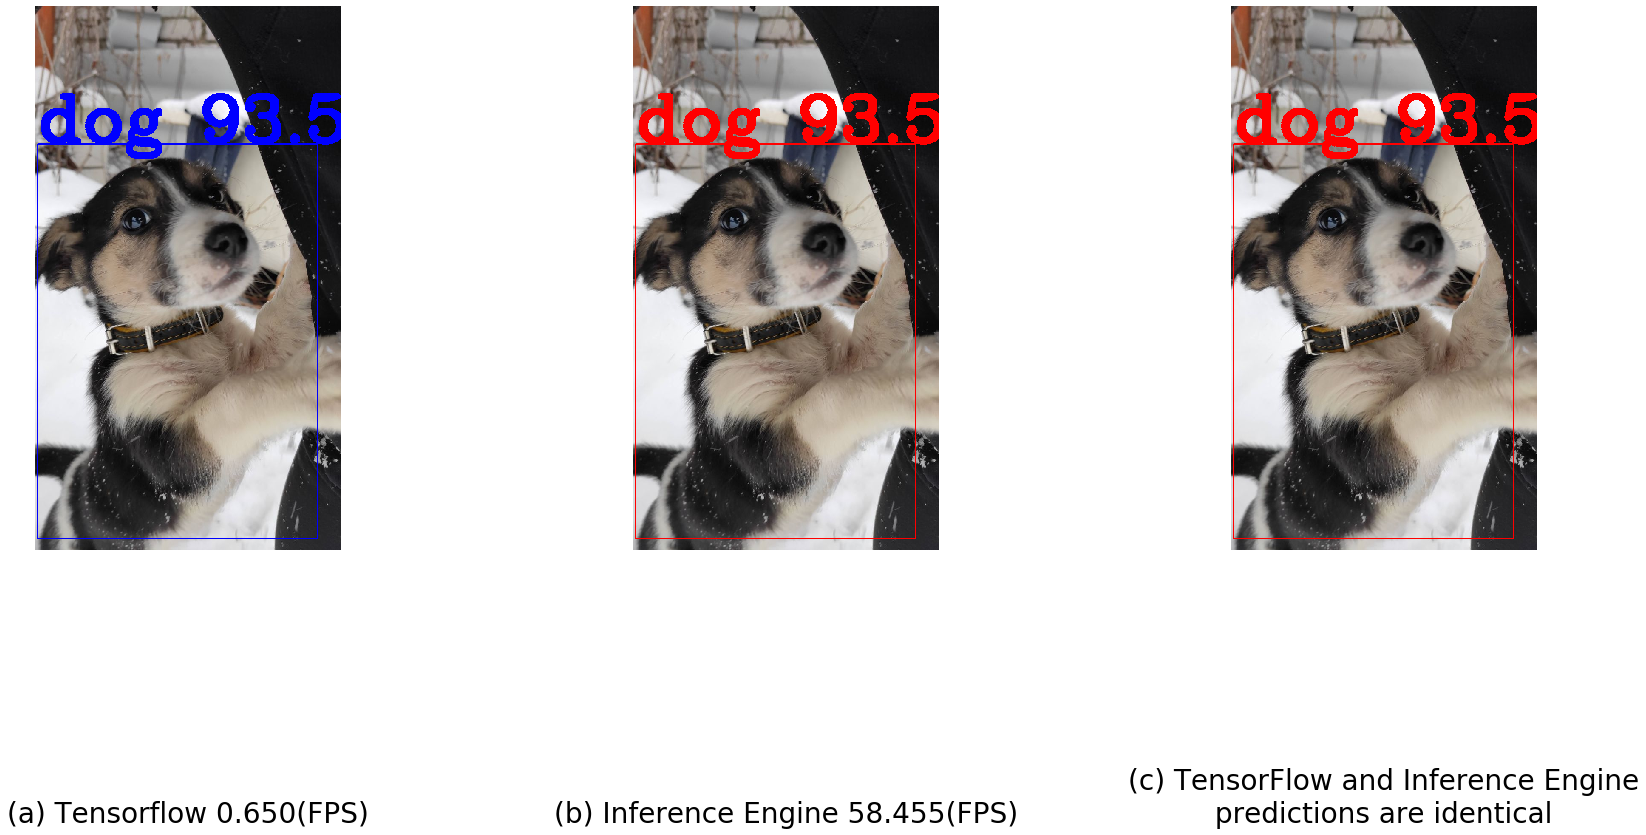

In [154]:
draw_image(TF_RESULT_IMAGE, predictions, COMBO_RESULT_IMAGE, color=(0, 0, 255))

show_results_interactively(tf_image=TF_RESULT_IMAGE,
                           ie_image=IE_RESULT_IMAGE,
                           combination_image=COMBO_RESULT_IMAGE,
                           ie_fps=ie_avg_fps,
                           tf_fps=tf_avg_fps)

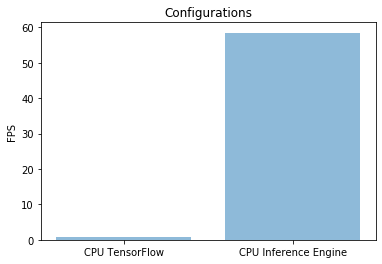

In [160]:
OBJECTS = ['CPU TensorFlow', 'CPU Inference Engine']
y_pos = np.arange(len(OBJECTS))
performance = [tf_avg_fps, ie_avg_fps]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, OBJECTS)
plt.ylabel('FPS')
plt.title('Configurations')
plt.show()